In [95]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import os
from glob import glob
from evaluate import compute_sim, evaluate, l2norm_numpy
from evaluate import dict2list

def l2norm(embs):
    return {k: v/np.linalg.norm(v) for k, v in embs.items()}

infer_dirs = glob('infer/*')[:]
# infer_dirs = infer_dirs[1:]
infer_dirs = [x for x in infer_dirs if 'bk' not in x]
infer_dirs = [x for x in infer_dirs if 'b5_pseudo_lb0.827' in  x]
weights = [1.0] * len(infer_dirs)
# weights = [1.0, 0.5, 0.5]

print(f"Ensemble of {len(infer_dirs)} models")

submit_file = f'submission.csv'
if os.path.exists('D:/whale_data/train_images-384-384/train_images-384-384'):
    train_img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
else:
    train_img_dir = '/Users/macbook/works/train_images-384-384'

norm=True
method = 'cat'

def get_emb(infer_dirs, subset, weights):
    li = []
    for infer_dir in infer_dirs:
        if isinstance(subset, str):
            embs = pickle_load(f"{infer_dir}/{subset}_emb.pkl")
        else:
            embs = {}
            for s in subset:
                p = f"{infer_dir}/{s}_emb.pkl"
                if os.path.exists(p):
                    embs = {**embs, **pickle_load(p)}
                elif s != "val":
                    raise FileNotFoundError(p)

        li.append(embs)

    if len(li) == 1:
        return li[0]

    print(f'Ensemble from {len(infer_dirs)} models {infer_dirs}')
    li0 = li[0]
    di = {}
    for k in li0.keys():
        di[k] = []
        for i in range(len(li)):
            e = li[i][k]
            if norm:
                e = e / np.linalg.norm(e)
            di[k].append(e)
        
        if method == 'cat':
            di[k] = np.concatenate(di[k], 0)
        else:
            # Mean
            di[k] = np.mean(di[k], 0)

    return di

train_df = pd.read_csv('data/train_kfold.csv')

run_val = False
try:
    train_embs = get_emb(infer_dirs, 'train', weights)
    test_embs = get_emb(infer_dirs, 'test', weights)
    val_embs = get_emb(infer_dirs, 'val', weights)

    train_embs = l2norm(train_embs)
    test_embs = l2norm(test_embs)
    val_embs = l2norm(val_embs)
    run_val = True
    print(len(train_embs) + len(val_embs))
except:
    pass



Ensemble of 1 models


In [119]:
import json

val_df = train_df[train_df.subset == 'test'].reset_index()
val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
spec_map = dict(zip(train_df.image, train_df.species))
id_map = {**train_map, **val_map}
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}
with open('individual_ids.json', 'r') as f:
    id2num = json.load(f)
    num2id = {v:k for k, v in id2num.items()}

In [97]:
from evaluate import compute_sim, evaluate, map_per_image, compute_simv2
from evaluate import *

if run_val:
    score, val_sim_df = evaluate(train_df, train_embs, val_embs, norm=True)
    val_sim_df["gt"] = val_sim_df.image.map(val_map)
    val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
    val_sim_df = val_sim_df.sort_values("map")
    print(score)

In [98]:
if run_val:
    train_k, train_v = dict2list(train_embs)
    test_k, test_v = dict2list(val_embs)
    class_count_df = train_df.groupby('individual_id').size().to_frame('count').reset_index()
    class_count = dict(zip(class_count_df.individual_id, class_count_df['count']))
    print(train_v.shape, test_v.shape)
    train_v = l2norm_numpy(train_v)
    test_v = l2norm_numpy(test_v)
    train_ids = np.unique([train_map[x] for x in train_k])
    allowed = []
    for i, k in enumerate(test_k):
        if train_map[k] in train_ids:
            allowed.append(i)
    test_k, test_v = [test_k[i] for i in allowed], [test_v[i] for i in allowed]
    cosines = np.matmul(test_v, train_v.T)

In [99]:
def add_border(img, color):
    bordersize = 14
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

if run_val:
    c = 0
    for i, scores in enumerate(cosines):
        if np.random.rand() < 0.1:
            top = 7
            sort_idx = np.argsort(-scores)
            topk = [train_k[j] for j in sort_idx[:top]]
            topk_score = [scores[j] for j in sort_idx[:top]]
            topk_id = [train_map[x] for x in topk]
            qid = test_k[i]
            gt = train_map[qid]
            c+=1
            imgs = [cv2.imread(f'{train_img_dir}/{qid}')[:,:,::-1]]
            for k, l in zip(topk, topk_id):
                im = cv2.imread(f'{train_img_dir}/{k}')[:,:,::-1]
                im = add_border(im, color=(255, 0, 0) if gt != l else (0, 128, 0))
                imgs.append(im)
            # Show image
            fig = plt.figure(figsize=(25, 4))
            columns = top + 1
            rows = 1
            for i2 in range(0, columns*rows):
                fig.add_subplot(rows, columns, i2+1)
                plt.title(f'{gt} {id_map[qid]}' if i2 == 0 else f'{topk_score[i2 - 1]:.2f} {id_map[topk[i2 -1]]}')
                plt.imshow(imgs[i2])
                plt.axis('off')
            
            plt.show()
            
        if c == 4:
            break
        

In [100]:
# val_sim_df

# sim_df = compute_sim(train_df, {**train_embs, **val_embs}, test_embs, thr=0.5, norm=True)
# sim_df[["image", "predictions"]].to_csv('submission.csv', index=False)
# sim_df.head()   

In [105]:
# assert False
from sklearn.neighbors import NearestNeighbors
n_neighbors = 100
knn = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine')

# diff fold
db_embs = get_emb(infer_dirs, ['train', 'val'], weights)
test_embs = get_emb(infer_dirs, 'test', weights)
test_pred = pickle_load(infer_dirs[0] + '/test_pred.pkl')

# db_embs = {**train_embs, **val_embs}

train_k, train_v = dict2list(db_embs)
test_k, test_v = dict2list(test_embs)
knn.fit(train_v)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [102]:
distances, idxs = knn.kneighbors(test_v, n_neighbors, return_distance=True)

In [124]:
from tqdm import tqdm

test_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(test_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        pred = test_pred[test_k[i]]
        top1_idx = np.argmax(pred)
        top1_conf = pred[top1_idx]
        top1_pred = num2id[top1_idx]
        tar = img2id[img_id]
        test_df.append([test_k[i], tar, d, top1_pred, top1_conf])

    
test_df = pd.DataFrame(test_df, columns=['image', 'target', 'distances', 'top1_pred', 'top1_conf'])
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target', 'top1_pred', 'top1_conf']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')
test_df.head(3)

100%|██████████| 27956/27956 [00:36<00:00, 775.48it/s]


,image,target,top1_pred,top1_conf,confidence
0,4a207f09a87442.jpg,29623de1f9a5,29623de1f9a5,1.0,0.999724
1,55a08e016c4f3f.jpg,5f2296c18e26,5f2296c18e26,1.0,0.999553
2,ee165335dc7cc2.jpg,fc0f7c162cc0,fc0f7c162cc0,1.0,0.999527


0.7924238088424668


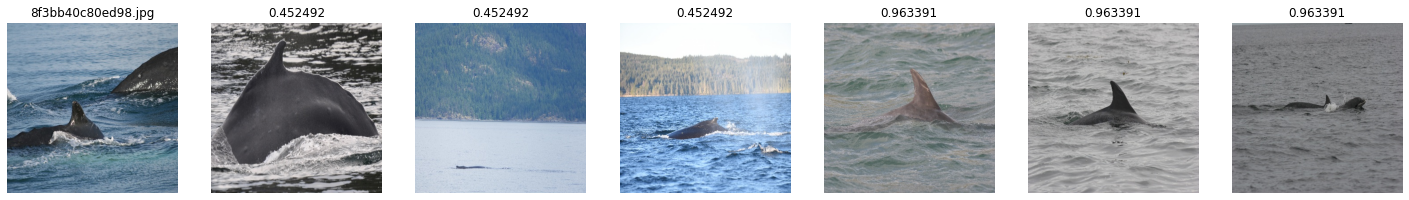

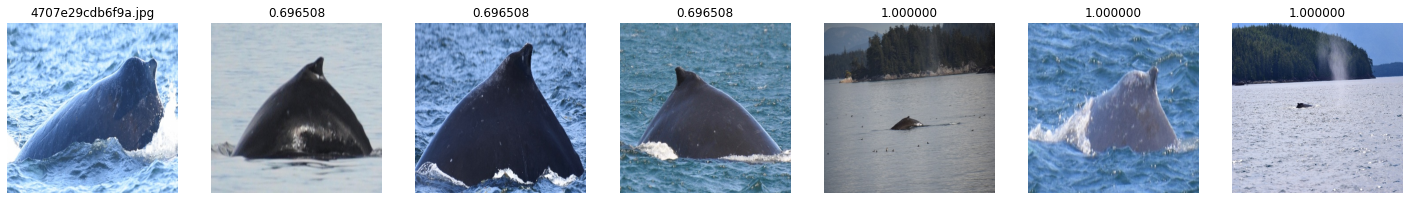

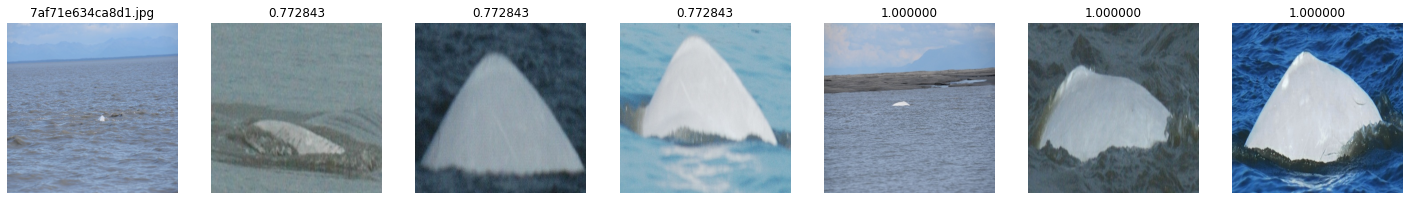

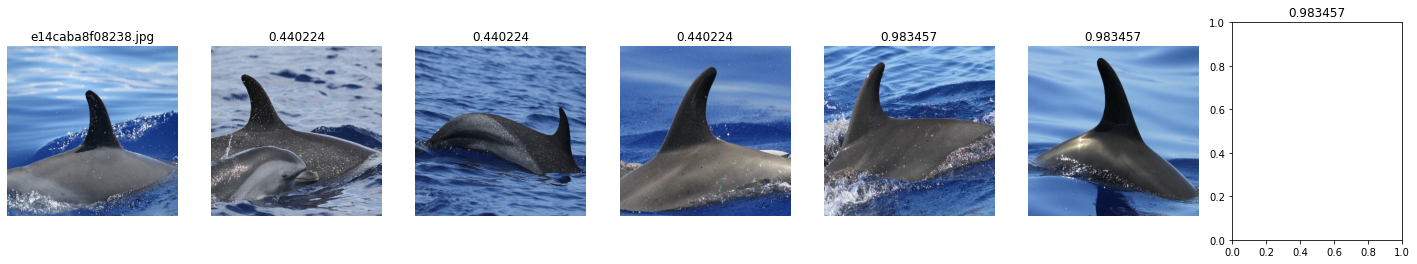

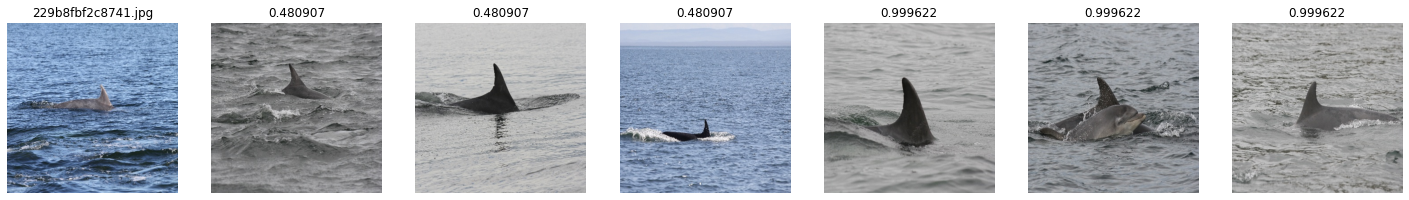

In [156]:
t = test_df.groupby(['image']).first().reset_index()
print((t['target'] == t['top1_pred']).mean())

# Show images
t = t.query('target != top1_pred & top1_conf >= 0.9')
samples = t.sample(5)

for i, row in samples.iterrows():
    # Show image
    fig = plt.figure(figsize=(25, 4))
    columns = 7
    rows = 1
    imgs = [cv2.imread(f'D:/whale384/test_images-384-384/test_images-384-384/{row["image"]}')[:,:,::-1]]
    imgs+= [cv2.imread(f'D:/whale384/train_images-384-384/train_images-384-384/{x}')[:,:,::-1]
            for x in train_df[train_df.individual_id == row['target']]['image'].values[:3]]
    imgs+= [cv2.imread(f'D:/whale384/train_images-384-384/train_images-384-384/{x}')[:,:,::-1]
            for x in train_df[train_df.individual_id == row['top1_pred']]['image'].values[:3]]

    for i2 in range(0, columns*rows):
        fig.add_subplot(rows, columns, i2+1)
        s = row["confidence"] if i2 < 4 else row["top1_conf"]
        plt.title(row["image"] if i2 == 0 else f'{s:3f}')
        if i2 < len(imgs):
            plt.imshow(imgs[i2])
            plt.axis('off')
    
    plt.show()

In [104]:
predictions = {}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

for i,row in tqdm(test_df.iterrows(), total=len(test_df)):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence >= 0.5  :
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

c = 0
for x in tqdm(predictions):
    if len(predictions[x])<5:
        c+=1
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])

print(c)
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv(submit_file,index=False)
predictions.head()

100%|██████████| 27956/27956 [00:00<00:00, 1217219.41it/s]

1110


,image,predictions
0,4a207f09a87442.jpg,29623de1f9a5 new_individual 027ac44f5b33 412be...
1,55a08e016c4f3f.jpg,5f2296c18e26 new_individual bb1844a67ceb 1a276...
2,ee165335dc7cc2.jpg,fc0f7c162cc0 new_individual eb0baf84857e 7ee26...
3,192618e6126546.jpg,84502c5db6bc new_individual 9e7a66e7ed2d 0f71e...
4,c0adcde2bf3539.jpg,29623de1f9a5 new_individual 412be6adfbf5 027ac...
